In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from math import sqrt

import DataAid
import DataImporter
import Neros

In [58]:
# Collect the data from each of the folders
sparcGalaxies = DataAid.GetGalaxyData("data/Sparc/Rotmod_LTG/")
littleDataGalaxies = DataAid.GetGalaxyData("data/little-data-things/data/")
lcmGalaxies = DataAid.GetGalaxyData("data/LCMFits/data/")
xueSofueGalaxies = DataAid.GetGalaxyData("data/XueSofue/")
mcGaughMW = DataAid.GetGalaxyData("data/McGaugh/")
# Get the galaxies we want from each source
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])
MWMcGaugh = np.array(mcGaughMW['MW_lumMcGaugh'])

# chi squared function
def chiSquared(observed, expected, error):
    chiSquared = 0
    
    for i in range(len(observed)):
        chiSquared = chiSquared + (((observed[i] - expected[i])**2) / (error[i]**2))
        
    return chiSquared / len(observed)

# Fit function
def simple(independents, alpha, vLumFreeParam, phiZero):
    # Parse out data for the galaxy
    rad,vLum = independents
    # Apply the vLum free param to the data
    vLum = vLum*vLumFreeParam
    # Calc vLCM with alpha free param
    vLcm = Neros.vLcm(rad, MW_vLum_interp_func(rad), vLum, phiZero)
    # Calc and return vNeros
    return Neros.vNeros(vLum, vLcm, alpha)

## Create the Milky Way interpolation function

In [59]:
MW_rad_XueSofue = MWXueSofue[:,0]
MW_vLum_XueSofue = MWXueSofue[:,1]
MW_rad_McGaugh = MWMcGaugh[:,0]
MW_vLum_McGaugh = MWMcGaugh[:,1]

# Change these to change MW model used for fitting
#MW_rad = MW_rad_McGaugh
#MW_vLum = MW_vLum_McGaugh
MW_rad = MW_rad_XueSofue
MW_vLum = MW_vLum_XueSofue

# this variable is used include MW model in fit data csv and graph png name 
# so we know which one we used to make the fit
#MW_name = "MWMcGaugh"
MW_name = "MWXueSofue"
# Interpolation function
MW_vLum_interp_func = interp1d(MW_rad, MW_vLum, kind='cubic')

## Running VNeros on every galaxy
We calculate vNeros for each galaxy and then plot the ratio between vNeros and the galaxy's vObs

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


galaxyName is: M31_Carignan_SNC
chiSquare is: 0.3438755033973134
fittedAlpha is: 157.81529359565408, 
fittedVLumFreeParam is: 0.9768874396597884
--------------------------
galaxyName is: NGC925_TokyCarignan_Original
chiSquare is: 11.21533458219256
fittedAlpha is: 2.317949088121177, 
fittedVLumFreeParam is: 1.0000184317784162
--------------------------
galaxyName is: N891_Fraternalli
chiSquare is: 1.2970819036883086
fittedAlpha is: 137.94338291508325, 
fittedVLumFreeParam is: 0.9711429848856175
--------------------------
galaxyName is: NGC7793_GentileTaM
chiSquare is: 29.63067873725418
fittedAlpha is: 3.185313842518937, 
fittedVLumFreeParam is: 1.0000204614574069
--------------------------
galaxyName is: M31_Carignan_SNC2
chiSquare is: 0.3005914141777014
fittedAlpha is: 157.0933371979689, 
fittedVLumFreeParam is: 0.9840634004696652
--------------------------
galaxyName is: NGC2403_Botteman_LCM
chiSquare is: 84.4940083786732
fittedAlpha is: 0.48490953995752756, 
fittedVLumFreeParam is: 0

/Users/sophiacisneros/Desktop/RCFM_Gen/RCFM/Neros.py:87: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.square(Other_Vlum) + (vLCM*freeParam) )


galaxyName is: NGC2903_Gentile TaM
chiSquare is: 3.7051855816562322
fittedAlpha is: 9743.425941505271, 
fittedVLumFreeParam is: 1.0740131253221197
--------------------------
galaxyName is: NGC2903 deBlok
chiSquare is: 20.508804620101746
fittedAlpha is: 30.69012306615401, 
fittedVLumFreeParam is: 0.9997432230946118
--------------------------
galaxyName is: M33_Corbelli_LCM
chiSquare is: 14.740672763989151
fittedAlpha is: 3.615653361356252, 
fittedVLumFreeParam is: 1.0000630848860552
--------------------------
galaxyName is: NGC5055_deBlok
chiSquare is: 34.25336741256946
fittedAlpha is: 447.921415333774, 
fittedVLumFreeParam is: 1.0005163285141596
--------------------------
galaxyName is: NGC7793_DicaireISO
chiSquare is: 1.6156326999298445
fittedAlpha is: 2.3100737650254413, 
fittedVLumFreeParam is: 0.9999820450919452
--------------------------
galaxyName is: N0891 Fraternalli
chiSquare is: 1.2970819036883086
fittedAlpha is: 137.94338291508325, 
fittedVLumFreeParam is: 0.9711429848856175

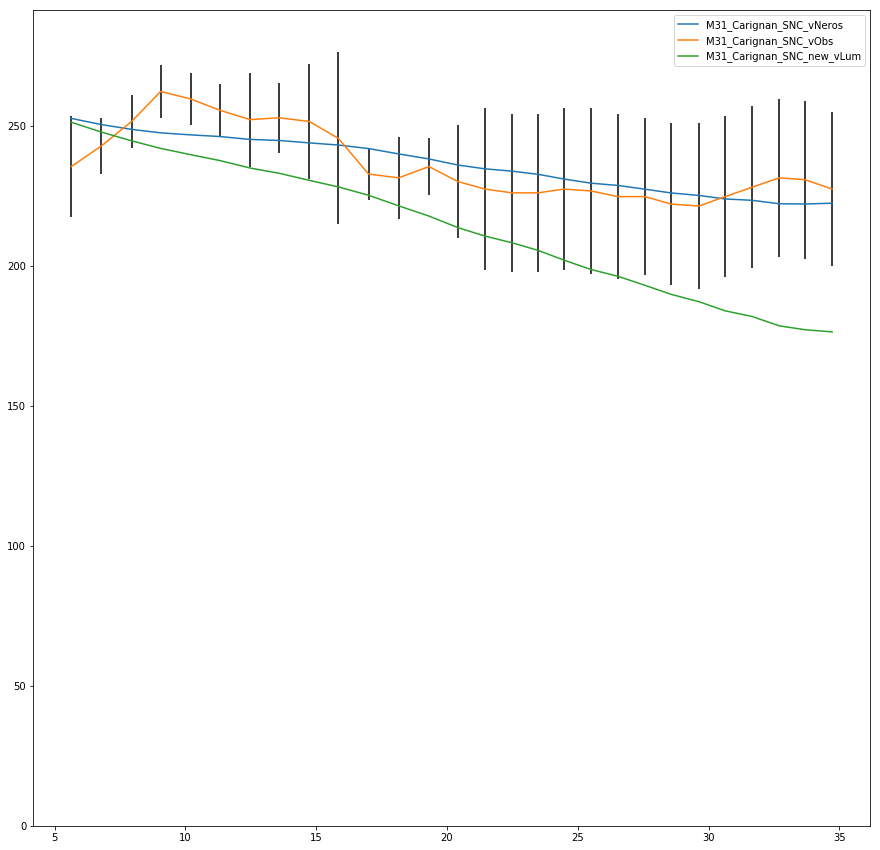

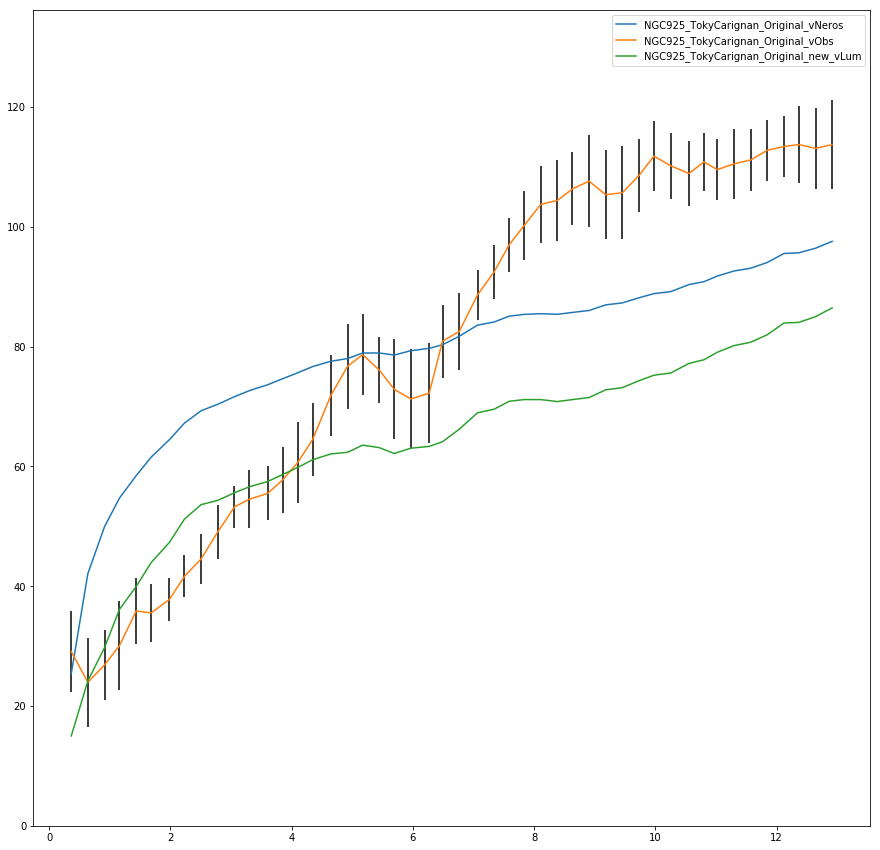

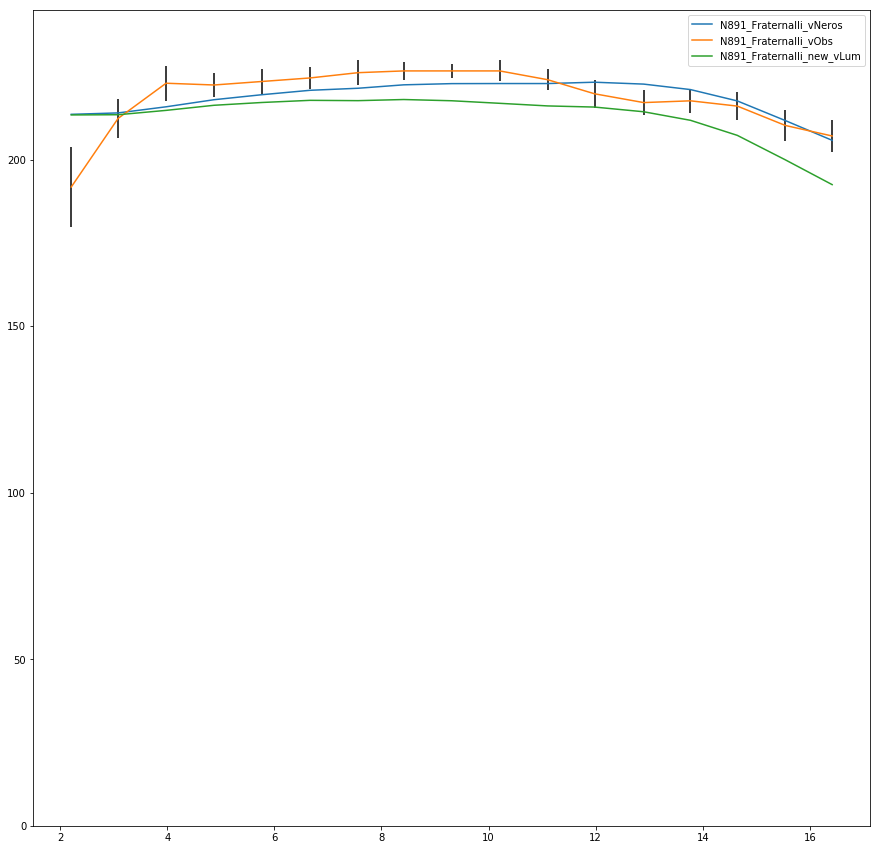

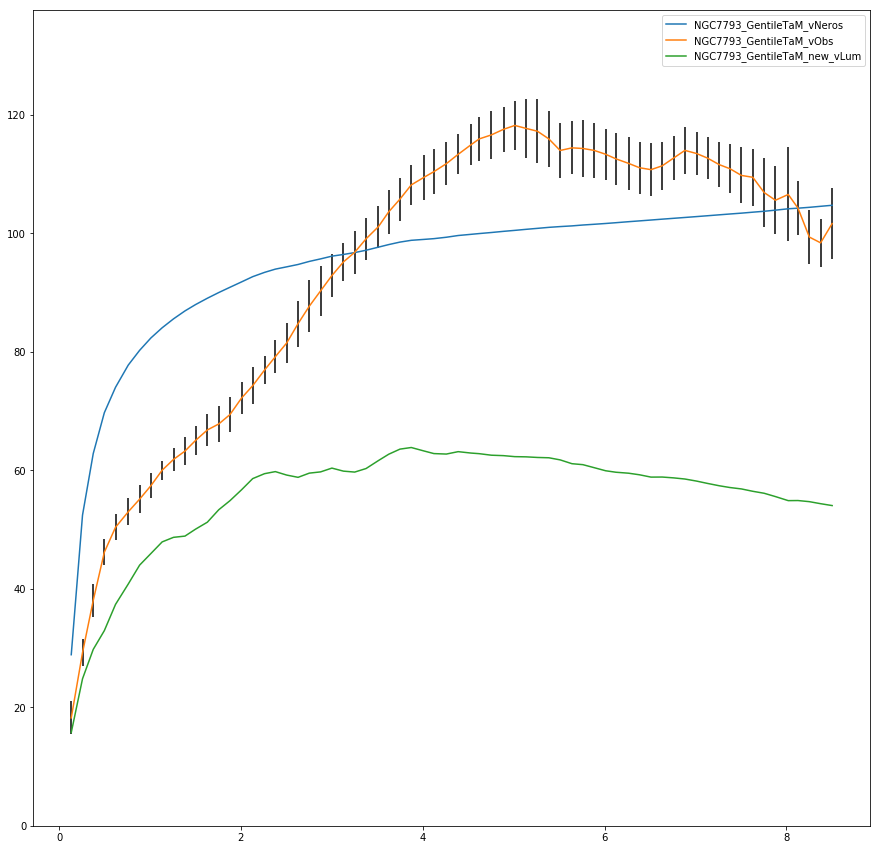

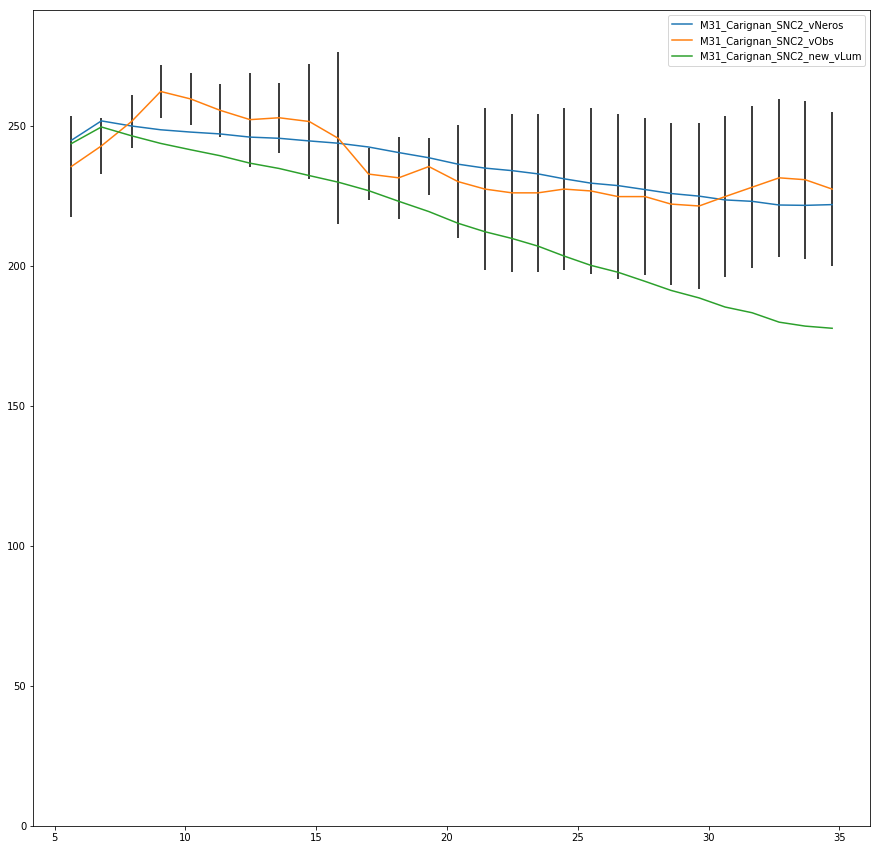

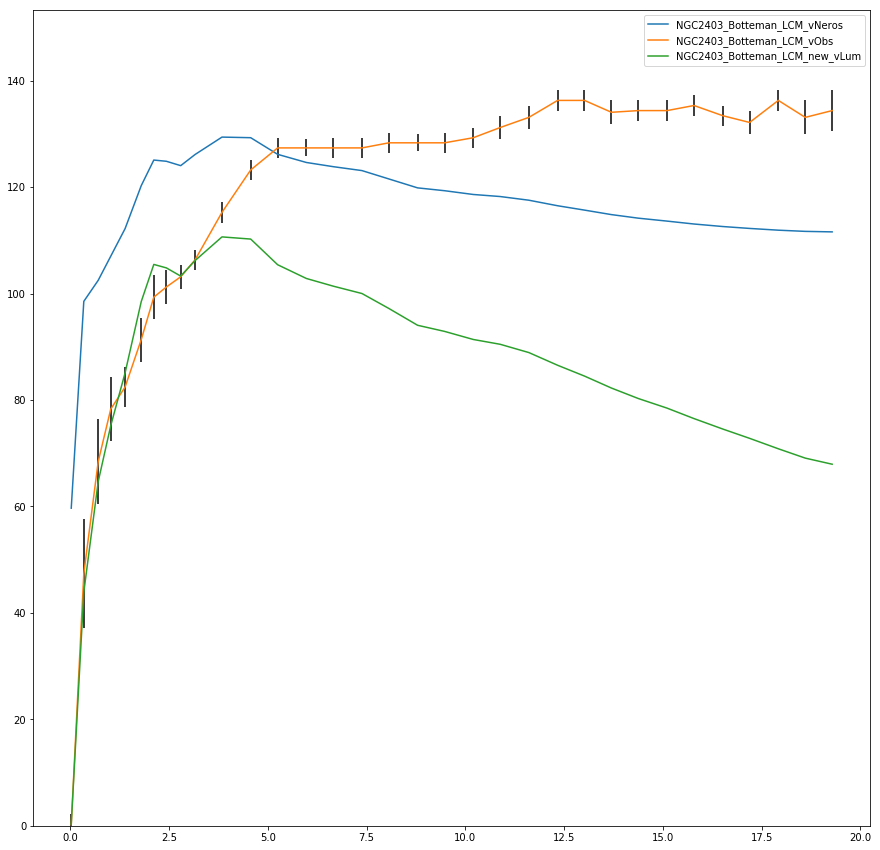

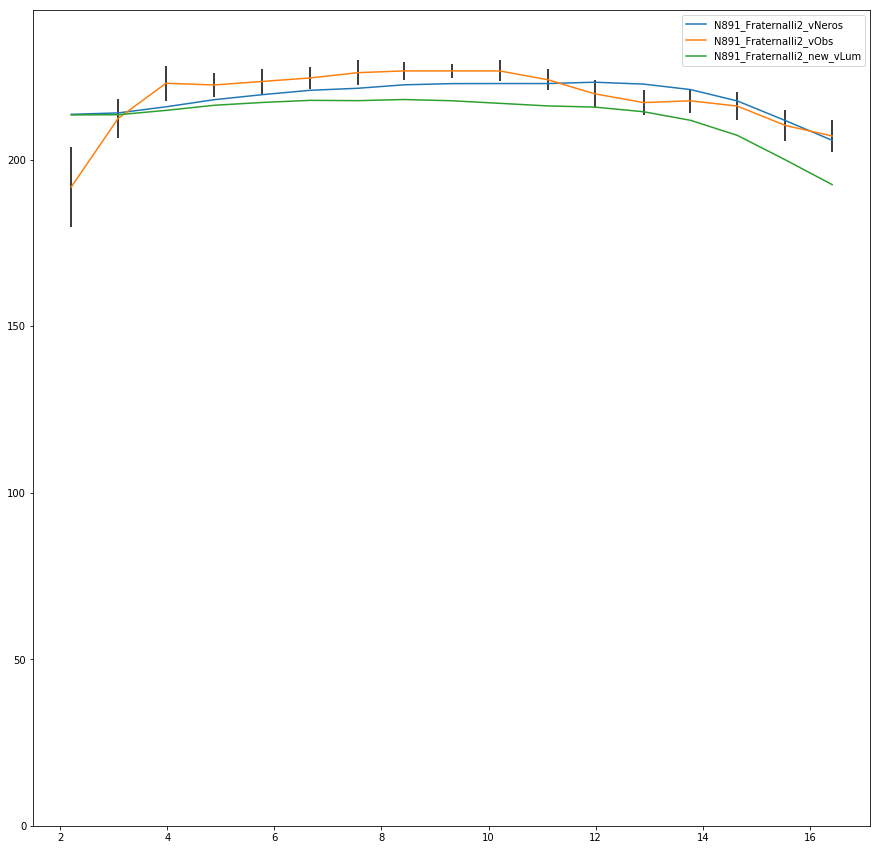

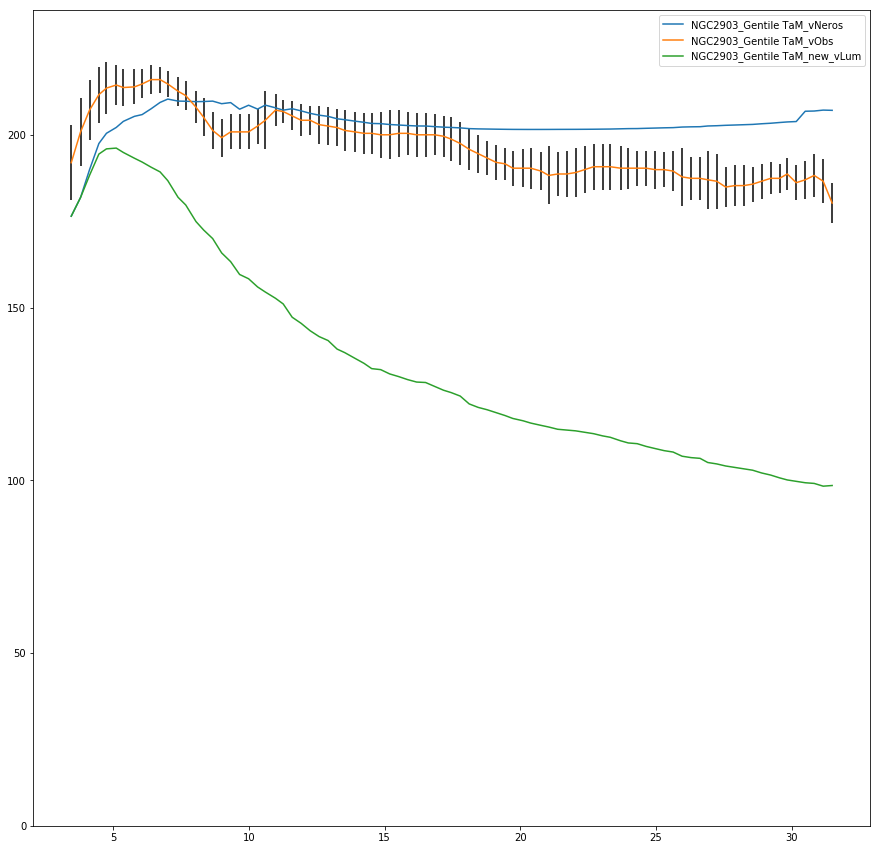

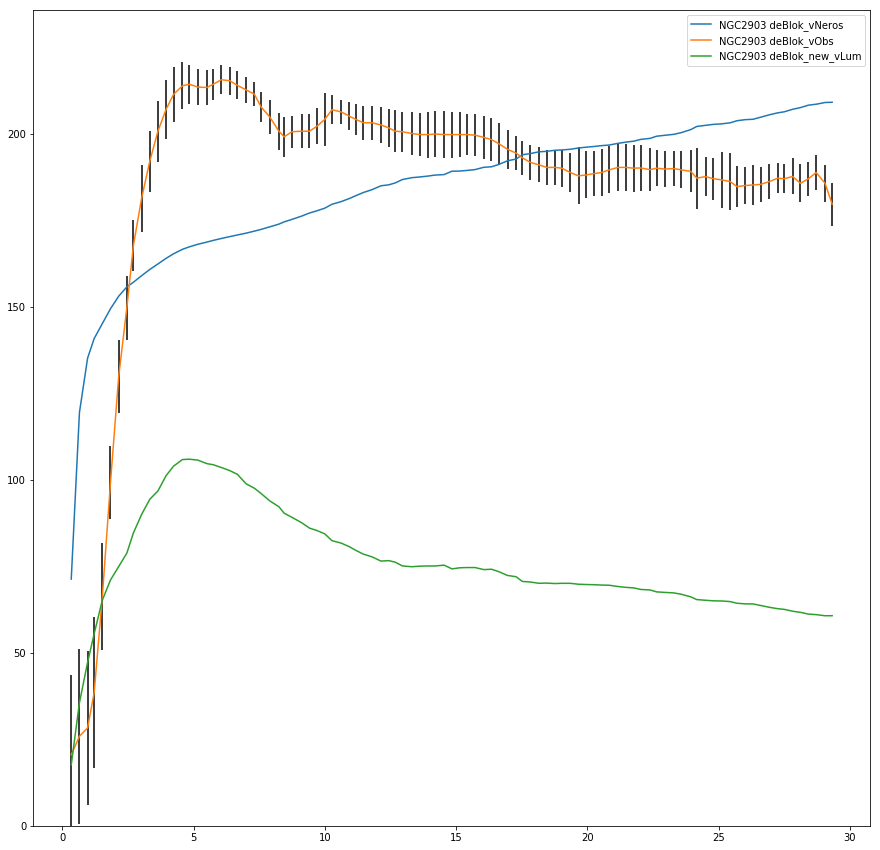

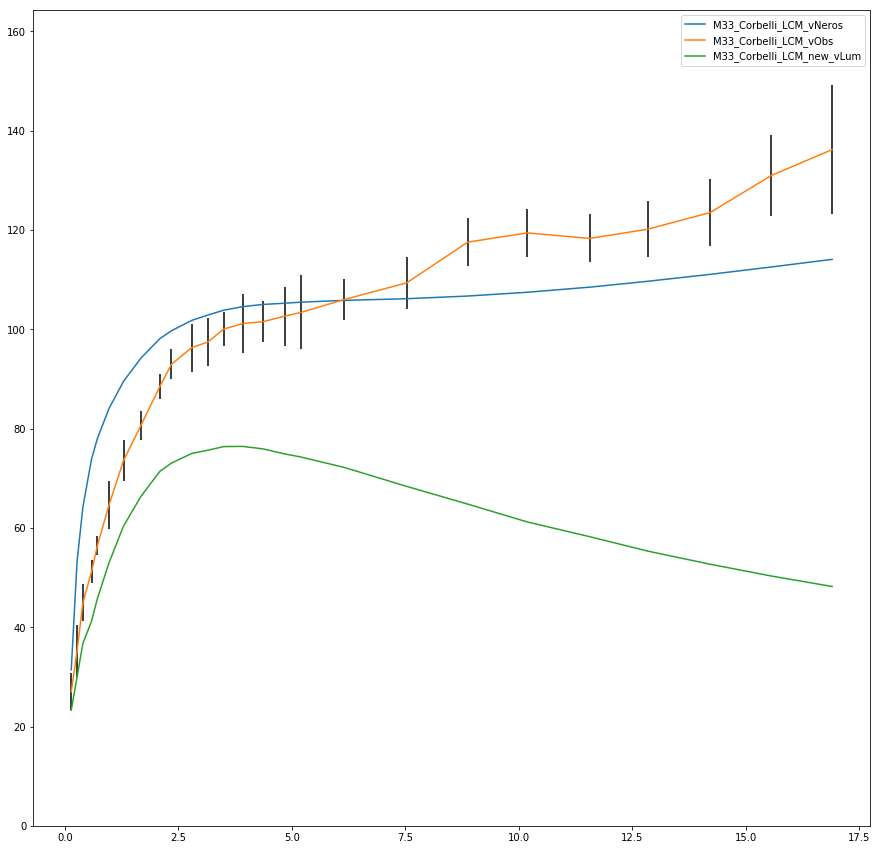

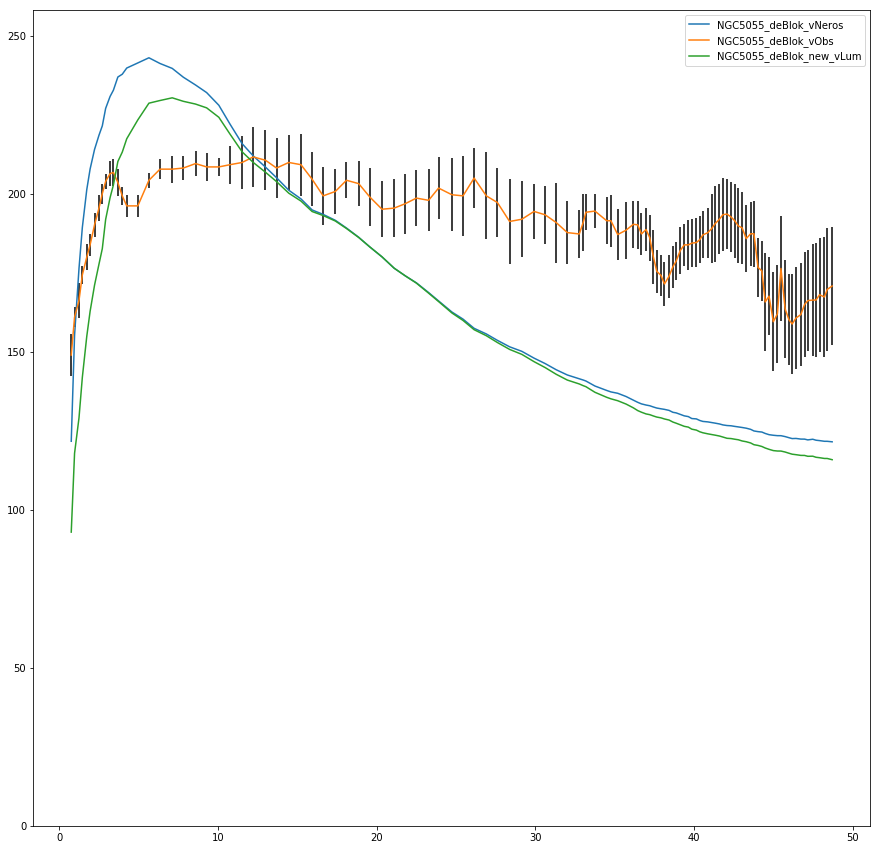

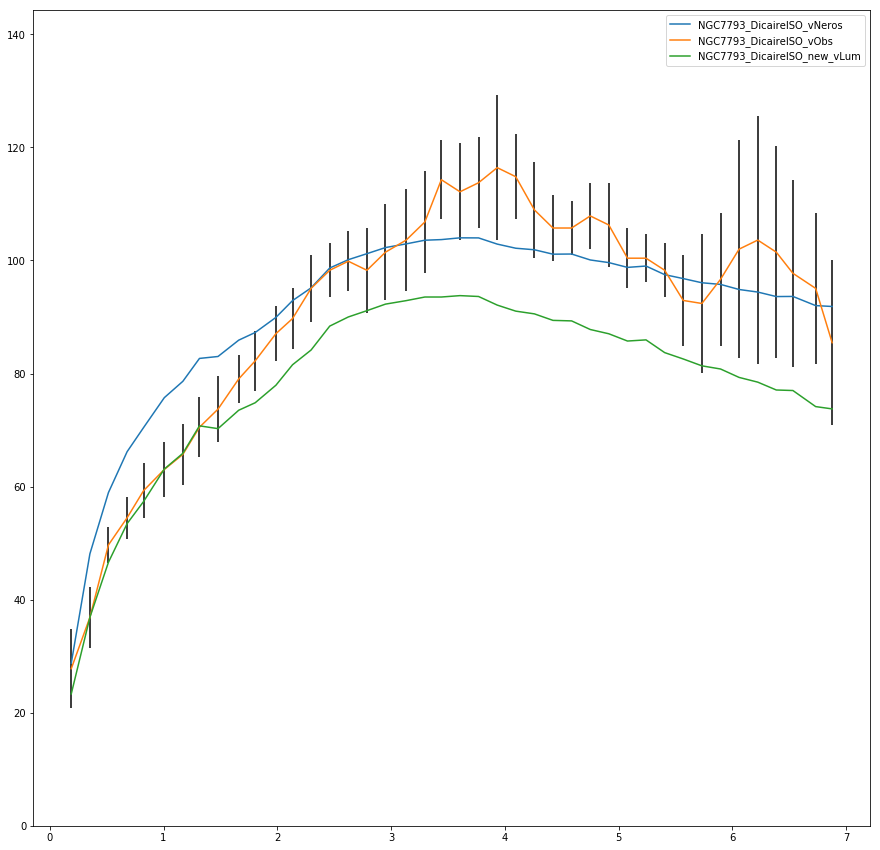

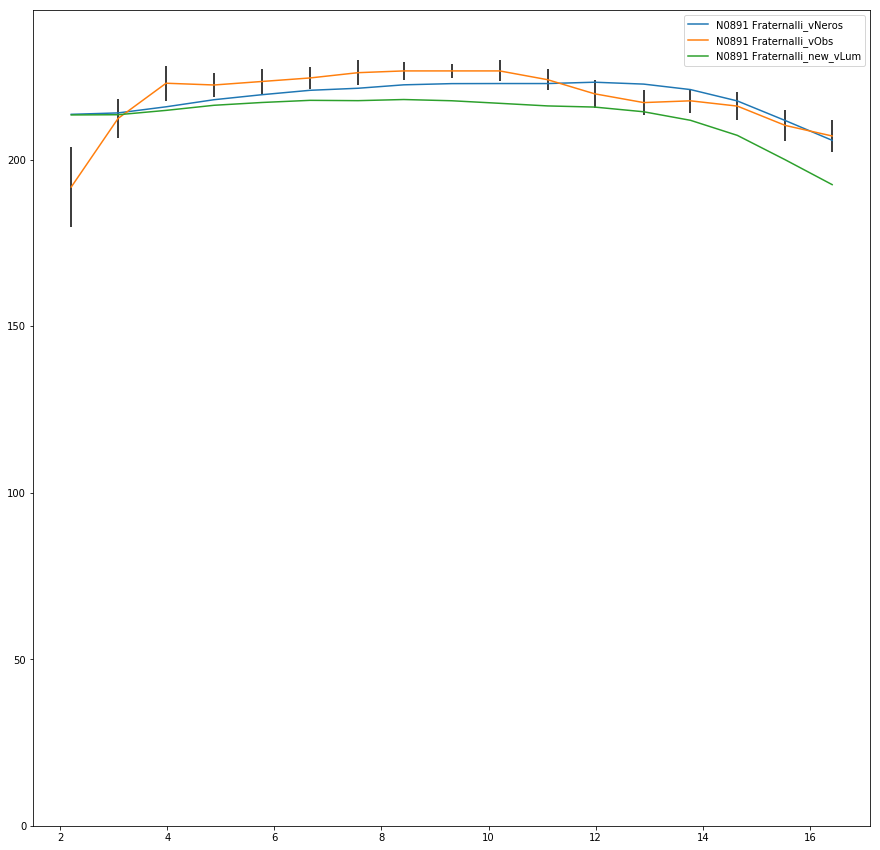

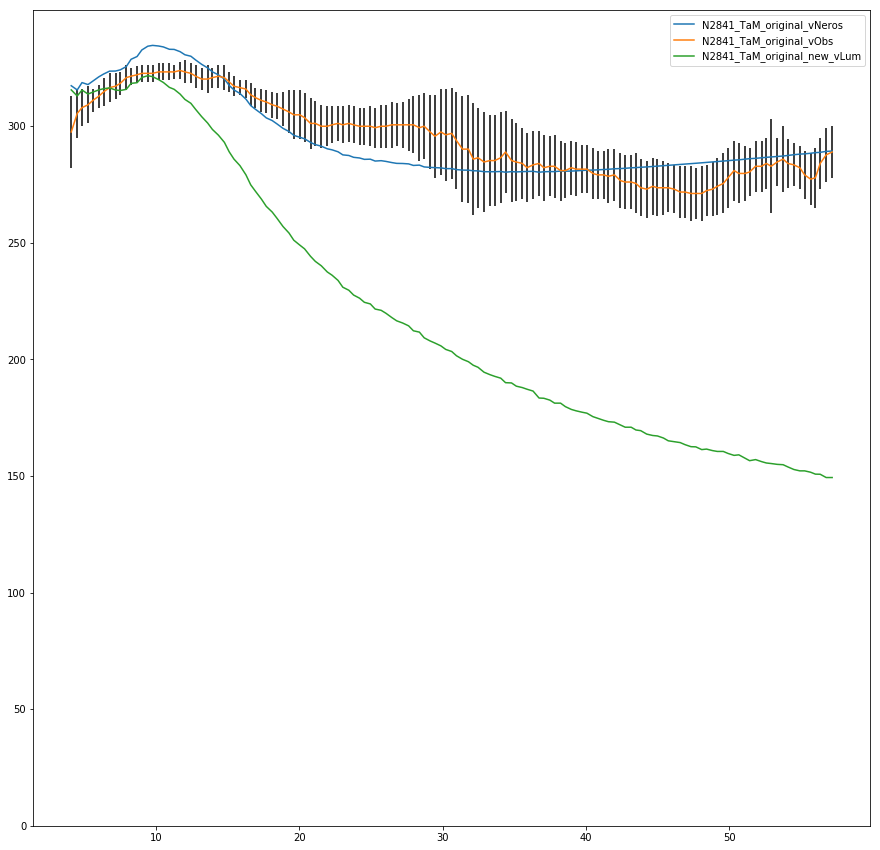

In [60]:
# This is where the fitted alpha & vlum free parameter will be written for each galaxy
out_file = "imported-data/data_" + str(MW_name) + ".csv"
with open(out_file, 'w') as f:
    f.write('{0},{1},{2}\n'.format("Galaxy", "Alpha", "Beta"))
f.close()

vLcmList = []

avgChiSquared = 0.0
avgPhiZero = 0.0

# Change this and uncomment if statement below if just one galaxy is desired.
galaxyWeWant = ""

for galaxyName in lcmGalaxies:
    # Uncomment the following two lines to produce data and graphs for just galaxyWeWant
    #if (galaxyName != galaxyWeWant):
     # continue
    
    # data on this galaxy
    f, ax = plt.subplots(1, figsize = (15, 15))
    galaxy = np.array(lcmGalaxies[galaxyName])
    galaxy_rad = galaxy[:,0]
    galaxy_vObs = galaxy[:,1]
    galaxy_error = galaxy[:,2]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]
    galaxy_vLumSquared = Neros.vLumSquared(galaxy_gas, galaxy_disk, galaxy_bulge)
    galaxy_vLum = np.sqrt(galaxy_vLumSquared)
    
    # Make sure the arrays are matching lengths
    maxMWRad = MW_rad[len(MW_rad)-1]
    for i in range(len(galaxy_rad)):
        if galaxy_rad[i] > maxMWRad:
            galaxy_rad = galaxy_rad[:i]
            galaxy_vLum = galaxy_vLum[:i]
            galaxy_vObs = galaxy_vObs[:i]
            break
    
    # fitter
    vals, cov = curve_fit(simple,(galaxy_rad, galaxy_vLum),galaxy_vObs)
    fittedAlpha, fittedVLumFreeParam, fittedPhiZero = vals

    avgPhiZero = avgPhiZero + fittedPhiZero
    
    # Run vLCM
    vLcm = Neros.vLcm(galaxy_rad, MW_vLum_interp_func(galaxy_rad), galaxy_vLum, fittedPhiZero)
    vLcmList.append(vLcm)
    vNeros = simple((galaxy_rad, galaxy_vLum), fittedAlpha, fittedVLumFreeParam, fittedPhiZero)
    ratio = vNeros/galaxy_vObs
    
    # printing to file & console
    chiSquare = chiSquared(galaxy_vObs, vNeros, galaxy_error)
    avgChiSquared = avgChiSquared + chiSquare
    print(f"galaxyName is: {galaxyName}")
    
    print(f"chiSquare is: {chiSquare}")
    
    print(f"fittedAlpha is: {fittedAlpha}, \nfittedVLumFreeParam is: {fittedVLumFreeParam}")
    
    #print(f"MW_Phi is: {Neros.phi(galaxy_rad, MW_vLum_interp_func(galaxy_rad))}")
    
    #print(f"Other_Phi is: {Neros.phi(galaxy_rad, galaxy_vLum)}")
    
    print("--------------------------")
    
    # Write galaxyName, fittedAlpha, fittedVLumFreeParam to file
    with open(out_file, 'a') as f:
        f.write('{0},{1},{2}\n'.format(galaxyName, fittedAlpha, fittedVLumFreeParam))
    f.close()
    
    # Calculate galaxy_vObs plus error and put into list
    galaxy_vObs_err_incl = []
    for i in range(len(galaxy_vObs)):
        galaxy_vObs_err_incl.append(galaxy_vObs[i] + galaxy_error[i])
        
    # calculate new vLum
    galaxy_vLum_updated = []
    for i in range(len(galaxy_vLum)):
        galaxy_vLum_updated.append(galaxy_vLum[i] * fittedVLumFreeParam)
        
    # plot
    # y-axis scales to the maximum velocity value in the list galaxy_vObs_err_incl
    # or to the maximum value in the list vNeros, whichever is the bigger number
    y_max = max(max(galaxy_vObs_err_incl), max(vNeros))
    ax.set_ylim(bottom = 0, top = y_max + 15)
    
    # plot vObs and vNeros and updated vLum
    ax.plot(galaxy_rad, vNeros, label="{}_vNeros".format(galaxyName))
    ax.plot(galaxy_rad, galaxy_vObs, label="{}_vObs".format(galaxyName))
    ax.plot(galaxy_rad, galaxy_vLum_updated, label="{}_new_vLum".format(galaxyName))
    
    # error bar in vObs
    for i in range(len(galaxy_rad)):
        ax.vlines(galaxy_rad[i], galaxy_vObs[i] - galaxy_error[i], galaxy_vObs[i] + galaxy_error[i])
        
    ax.legend(loc="upper right")

    graph_file_name = "graphs/" + str(galaxyName) + "_" + str(MW_name)

    plt.savefig(graph_file_name)

print(avgChiSquared / len(lcmGalaxies))
#print(avgPhiZero / len(lcmGalaxies))
#print Neros.kappa(MW_phi, Other_phi, phiZero)

    

In [61]:
!ls -la data/McGaugh/


total 8
drwxr-xr-x  3 sophiacisneros  staff    96 Oct 16 14:52 .
drwxr-xr-x  9 sophiacisneros  staff   288 Oct 28 17:30 ..
-rw-r--r--@ 1 sophiacisneros  staff  1202 Oct 16 06:07 MW_lumMcGaugh.txt


In [62]:
!rm data/McGaugh/.DS_Store


rm: data/McGaugh/.DS_Store: No such file or directory
